# Analysis of CO2 emission data 

The German Emissions Trading Authority ("Deutsche Emissionshandelsstelle" or short DEHSt) in the Federal Environment Agency (UBA) is the national authority responsible for implementing the European Emissions Trading System (EU-ETS) and the national emissions trading system (nEHS).

The DEHSt works closely with the companies whose installations, aircraft, ships or fuels are subject to emissions trading. It supports the work of inspection bodies and is also the contact point for the Federal Ministry for the Environment, Nature Conservation, Nuclear Safety and Consumer Protection, the Federal Ministry for Economic Affairs and Climate Protection, the federal states and the responsible state immission control authorities.

Its goal is to lead emissions trading to ecological and economic success and thus make a significant contribution to achieving the ambitious climate protection targets of the federal government.

DEHSt publishes [data on CO2 emission](https://www.dehst.de/SharedDocs/downloads/DE/anlagenlisten/2021-2030/2022.pdf?__blob=publicationFile&v=2) that are subject to emission trading year.

Now we will have a look on these data.

The data comes in a PDF file. As a first step, I converted the tables from the PDF file to Excel. This extensive step is outsourced to another python-script (dehst\extract.py). Now we can directly load the data into a Pandas data frame.

In [5]:
import pandas as pd
data = pd.read_excel(r".\dehst\2022.xlsx")
data.head()

,Unnamed: 0,Anlagen ID,Anlagen Nummer,Betreiber,Anlagenname,Bundesland,PLZ,Standort der Anlage,Emissionen 2005 bis 2007 Gesamt in [t CO2],Emissionen 2005 bis 2007 Durchschnitt/ Jahr in [t CO2],Emissionen 2008 bis 2012 Gesamt in [t CO2],Emissionen 2008 bis 2012 Durchschnitt/ Jahr in [t CO2],Emissionen 2013 bis 2020 Gesamt in [t CO2],Emissionen 2013 bis 2020 Durchschnitt/ Jahr in [t CO2],Emissionen 2018 in [t CO2],Emissionen 2019 in [t CO2],Emissionen 2020 in [t CO2],Emissionen 2021 in [t CO2],Emissionen VET 2022 in [t CO2],Zuteilung 2005 bis 2007 Gesamt in [EUA],Zuteilung 2005 bis 2007 Durchschnitt/ Jahr in [EUA],Zuteilung 2008 bis 2012 Gesamt in [EUA],Zuteilung 2008 bis 2012 Durchschnitt/ Jahr in [EUA],Zuteilung Zuteilung 2013 bis 2020 Gesamt in [EUA],Zuteilung 2013 bis 2020 Durchschnitt/ Jahr in [EUA],Zuteilung 2018 in [EUA],Zuteilung 2019 in [EUA],Zuteilung 2020 in [EUA],Zuteilung 2021 in [EUA],Zuteilung 2022 in [EUA],Kleinemitten 4. HP,Haupttätigkeit nach TEHG t Nr. Bezeichnung,Haupttätigkeit nach TEHG t Nr. Bezeichnung Bezeichnung
0,0,1.0,14210-0001,Gunvor Raffinerie Ingolstadt\nGmbH,Mineraloelraffinerie,BY,85003,Ingolstadt,2.414.312,804.771,3.493.875,698.775,5.720.514,715.064,736.032,740.764,626.614,656.151,679.472,2.640.039,880.013,4.285.115,857.023,4.556.874,569.609,590.548,577.592,564.638,471.357,471.357,NaN,7,Raffinerien
1,1,2.0,14210-0002,Haltermann Carless\nDeutschland GmbH,Werk Speyer,RP,67346,Speyer,107.355,35.785,98.185,19.637,52.803,6.600,464,190,265,434,448,113.991,37.997,189.590,37.918,42.665,5.333,0,0,0,keine\nZuteilung,keine\nZuteilung,x,7,Raffinerien
2,2,3.0,14210-0003,Ruhr Oel GmbH,Werk Horst – CO-Glocke\n2,NW,45896,Gelsenkirchen,3.155.266,1.051.755,5.352.697,1.070.539,8.486.528,1.060.816,799.753,949.077,973.825,1.016.652,1.105.424,3.151.710,1.050.570,5.233.530,1.046.706,6.399.589,799.949,777.230,761.580,745.876,593.793,593.793,NaN,7,Raffinerien
3,3,4.0,14210-0004,Ruhr Oel GmbH BP\nGelsenkirchen,Werk Scholven – CO-Glocke\n2,NW,45896,Gelsenkirchen,11.007.578,3.669.193,18.196.546,3.639.309,25.215.665,3.151.958,2.858.225,3.008.236,2.789.256,3.010.072,3.078.302,10.913.541,3.637.847,17.973.466,3.594.693,22.462.098,2.807.762,2.728.023,2.673.092,2.617.971,2.232.165,2.172.298,NaN,7,Raffinerien
4,4,5.0,14210-0005,OMV Deutschland Operations\nGmbH & Co. KG,Mineralölverarbeitung,BY,84489,Burghausen,2.804.139,934.713,5.566.870,1.113.374,8.686.291,1.085.786,1.086.239,1.131.866,1.092.550,1.108.174,960.452,3.031.667,998.252,6.553.245,1.310.649,6.402.481,800.310,778.012,762.368,746.671,881.841,882.574,NaN,7,Raffinerien


I want to print the emissions to a map. The problem is, that the data are not geolocated.

Options, to geolocate this data are
1. Google maps API
2. Link data to a map with postal code areas

The problem with Google maps is, that the adresses of the companies refer to the office buildings, but not to the industrial facilities. And we are interested in the locations of the industrial facilities. This means Google maps does not provide a robust solution for our task.

There is another problem with the postal codes. The data set contains postal codes that refer to lockboxes.

To reduce the complexity of this task, we add the data to a map, where the areas are combined to the first two digits.

<Axes: >

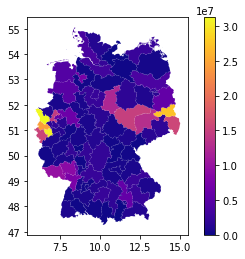

In [11]:
import geopandas as gpd

plz = gpd.read_file(r".\plz-2stellig\plz-2stellig.shp") # shape file with two digit postal code area
data_2021 = data[["PLZ ", "Emissionen 2021 in [t CO2]"]].copy() # copy relevant data only

# Some cleaning
data_2021["Emissionen 2021 in [t CO2]"] = data_2021["Emissionen 2021 in [t CO2]"].map(lambda x: x.replace(".", ""))
data_2021["Emissionen 2021 in [t CO2]"] = pd.to_numeric(data_2021["Emissionen 2021 in [t CO2]"], errors="coerce")

# First two digits of postal code
PLZ_5 = [('0' + str(b)) if (b < 10000) else str(b) for b in data_2021['PLZ ']]
PLZ_2 = [i[:2] for i in PLZ_5]
data_2021["PLZ_2"] = PLZ_2

# Sum up emissions for every postal code area and merge 
data_2021 = data_2021.groupby(['PLZ_2'])["Emissionen 2021 in [t CO2]"].sum().reset_index()
plz = pd.merge(plz, data_2021, left_on='plz', right_on='PLZ_2', how='left')

# No data in table for plz area 61
plz["Emissionen 2021 in [t CO2]"] = plz["Emissionen 2021 in [t CO2]"].fillna(0)

# plot map
%matplotlib inline
plz.plot(column="Emissionen 2021 in [t CO2]", cmap='plasma', legend=True)